# Imports

In [633]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os
import pickle
from tqdm import tqdm

from sklearn.compose import (
	ColumnTransformer
)
from sklearn.decomposition import (
	PCA
)
from sklearn.ensemble import (
	RandomForestClassifier
)
from sklearn.linear_model import (
	LogisticRegression
)
from sklearn.metrics import (
	confusion_matrix, classification_report, f1_score,
)
from sklearn.model_selection import (
	train_test_split, RandomizedSearchCV, GridSearchCV, 
	cross_val_score,
)
from sklearn.pipeline import (
	Pipeline
)
from sklearn.preprocessing import (
	LabelEncoder, OneHotEncoder, StandardScaler,
	RobustScaler, QuantileTransformer,
)
import statsmodels.api as sm

In [634]:
SEED = 123
TEST_SIZE = 0.25

HEATMAP_COLORS = sns.diverging_palette(h_neg=359, h_pos=250, as_cmap=True)


# Import/Preprocess Data

In [697]:
df = pd.read_pickle(Path('../data/df.pickle'))

# Identify columns to drop
ID_FEAT_TODROP = [
	'pe_study_number',
	'patient_id',
	'series_id',
	'slice_number',
]
NONID_FEAT_TODROP = [
	'gender_pe',
	'dob_mask_pe',
	'study_age_cl',
	'study_date_mask_cl',
]
FEAT_TODROP = ID_FEAT_TODROP + NONID_FEAT_TODROP
# Check columns to drop are named correctly
assert set(FEAT_TODROP).issubset(set(df.columns))
# Subset to first CT observation
df_first = df.loc[df.pe_obs==0, :]
df_all = df.copy()
# Set index to PE number
df_all.index = df_all.pe_study_number + '_' + df_all.pe_obs.apply(str)
df_first.index = df_first.pe_study_number + '_' + df_first.pe_obs.apply(str)
# Drop columns
df_all = df_all.loc[:, df_all.columns.difference(FEAT_TODROP)]
df_first = df_first.loc[:, df_first.columns.difference(FEAT_TODROP)]
# Check shape
print(f"DF All Shape: {df_all.shape}")
print(f"DF Shape: {df_first.shape}")
# Check head
df_all.head()

DF All Shape: (104, 106)
DF Shape: (48, 106)


,a_diameter,age,airway_ratio,airway_volume,anterior_basal_rs8,anterior_ls3,anterior_rs3,anteromedial_basal_ls7_8,apical_ls1,apical_rs1,...,ve_vco2_slope,vo2_hr_peak_percent_,vo2_ml_kg_min_at_at,vo2_work_slope_output,volume_bone,volume_intermuscular_fat,volume_muscle,volume_subcutaneous_fat,volume_visceral_fat,weight_kg
PE1_0,26.7526,49.0,0.011805,0.066788,0.201809,0.206637,0.326371,0.06566,0.0,0.399756,...,NaN,45.0,9.6,NaN,2.03983,0.986196,5.87431,6.59418,0.242408,150.00
PE12_0,21.0758,45.0,0.014465,0.069840,0.395899,0.000000,0.002098,0.00000,0.0,0.041968,...,29.557,75.0,10.7,8.038,1.85461,0.904912,6.00182,4.86750,1.988060,111.50
PE12_1,22.9284,45.0,0.018161,0.047697,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,...,29.557,75.0,10.7,8.038,2.02425,0.629943,8.01657,6.28189,2.443480,111.50
PE14_0,22.3061,31.0,0.010895,0.054162,0.238598,0.000000,0.000000,0.00000,0.0,0.000000,...,32.776,92.0,10.2,7.718,1.68335,0.347496,5.08316,4.88387,0.470233,85.55
PE15_0,17.0060,18.0,0.013111,0.029738,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,...,28.446,80.0,17.1,NaN,1.16264,0.168386,3.62723,1.53712,0.017716,55.00


## Detect Outliers

There is one patient (PE37) who has a `total_clot_burden` value above 200. For now, we will remove this patient as an outlier, but mark for future investigation.

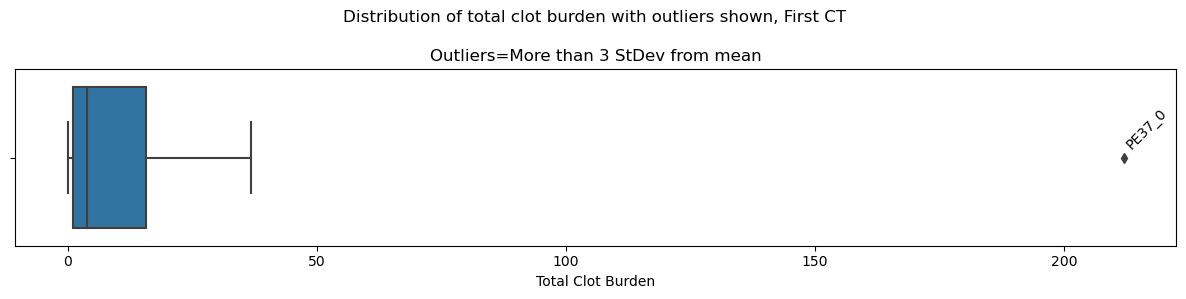

(47, 106)

In [698]:
# Calculate z-scores for each data point
z_scores = (df_first.total_clot_burden - df_first.total_clot_burden.mean()) / df_first.total_clot_burden.std()
# Define a threshold for outlier detection
threshold = 3
# Find the indices of outliers
outlier_indices = z_scores[abs(z_scores) > threshold].dropna().index

fig = plt.figure(figsize=(12, 3))
sns.boxplot(data=df_first, x='total_clot_burden')

for outlier_idx in list(outlier_indices):
	plt.annotate(
		outlier_idx,
		xy=(0, 0), xytext=(df_first.loc[outlier_idx, 'total_clot_burden'], -0.05), 
		textcoords='data', rotation=45
	)

plt.suptitle('Distribution of total clot burden with outliers shown, First CT')
plt.title('Outliers=More than 3 StDev from mean')
plt.xlabel('Total Clot Burden')

plt.tight_layout()
plt.savefig('../figures/clot_burden_outliers_first.png')
plt.show()

# Drop outliers
df_first = df_first.drop(index=outlier_indices)
df_first.shape

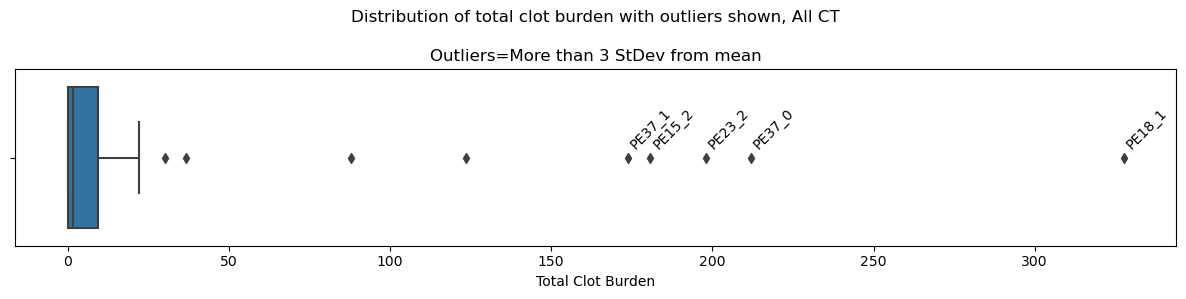

(99, 106)

In [699]:
# Calculate z-scores for each data point
z_scores = (df_all.total_clot_burden - df_all.total_clot_burden.mean()) / df_all.total_clot_burden.std()
# Define a threshold for outlier detection
threshold = 3
# Find the indices of outliers
outlier_indices = z_scores[abs(z_scores) > threshold].dropna().index

fig = plt.figure(figsize=(12, 3))
sns.boxplot(data=df_all, x='total_clot_burden')

for outlier_idx in list(outlier_indices):
	plt.annotate(
		outlier_idx,
		xy=(0, 0), xytext=(df_all.loc[outlier_idx, 'total_clot_burden'], -0.05), 
		textcoords='data', rotation=45
	)

plt.suptitle('Distribution of total clot burden with outliers shown, All CT')
plt.title('Outliers=More than 3 StDev from mean')
plt.xlabel('Total Clot Burden')

plt.tight_layout()
plt.savefig('../figures/clot_burden_outliers_all.png')
plt.show()

# Drop outliers
df_all = df_all.drop(index=outlier_indices)
df_all.shape

## Identify Target and Independent Variables

In [700]:
# Identify all target columns
# In this case, they will be PE resolution and all 
# clot burden variables.
CAT_TARGETS = [
	'resolved_pe'
]
NUM_TARGETS = [
	'total_clot_burden',
	'centralartery',
	'apical_rs1',
	'posterior_rs2',
	'anterior_rs3',
	'lateral_rs4',
	'medial_rs5',
	'superior_rs6',
	'medial_basal_rs7',
	'anterior_basal_rs8',
	'lateral_basal_rs9',
	'posterior_basal_rs10',
	'apical_ls1',
	'posterior_ls2',
	'anterior_ls3',
	'superior_ls4',
	'inferior_ls5',
	'superior_ls6',
	'anteromedial_basal_ls7_8',
	'lateral_basal_ls9',
	'posterior_basal_ls10',
]
TARGETS = CAT_TARGETS + NUM_TARGETS
# Check columns to drop are named correctly
assert set(TARGETS).issubset(set(df_first.columns))
assert set(TARGETS).issubset(set(df_all.columns))
# Separate X
X_first = df_first.loc[:, df_first.columns.difference(TARGETS)].select_dtypes(['int', 'float'])
X_all = df_all.loc[:, df_all.columns.difference(TARGETS)].select_dtypes(['int', 'float'])
# Separate Y
Y_first = df_first.loc[:, TARGETS]
Y_all = df_all.loc[:, TARGETS]

print(f"X_all.shape: {X_all.shape}")
print(f"X_first.shape: {X_first.shape}")
print(f"Y_all.shape: {Y_all.shape}")
print(f"Y_first.shape: {Y_first.shape}")

X_all.shape: (99, 65)
X_first.shape: (47, 65)
Y_all.shape: (99, 22)
Y_first.shape: (47, 22)


In [639]:
VFAT_FEAT = ['volume_visceral_fat', 'density_visceral_fat', 'mass_visceral_fat']
SFAT_FEAT = ['volume_subcutaneous_fat', 'density_subcutaneous_fat', 'mass_subcutaneous_fat']
IFAT_FEAT = ['volume_intermuscular_fat', 'density_intermuscular_fat', 'mass_intermuscular_fat']
MUSCLE_FEAT = ['volume_muscle', 'density_muscle', 'mass_muscle']
BONE_FEAT = ['volume_bone', 'density_bone', 'mass_bone']
BODY_FEAT = VFAT_FEAT + SFAT_FEAT + IFAT_FEAT + MUSCLE_FEAT + BONE_FEAT

# OLS Regressions

## Standardize Data

In [640]:
# Standardize data
scaler = StandardScaler()
X_scale_first = pd.DataFrame(
	scaler.fit_transform(X_first),
	columns=X_first.columns,
	index=X_first.index
)
X_scale_all = pd.DataFrame(
	scaler.fit_transform(X_all),
	columns=X_all.columns,
	index=X_all.index
)

print(f"X_body_first.shape: {X_scale_first.shape}")
print(f"X_body_all.shape: {X_scale_all.shape}")

X_body_first.shape: (47, 65)
X_body_all.shape: (99, 65)


## Dependent Variable: Clot Burden

In [641]:
# X_temp = sm.add_constant(X_body.loc[:, 'volume_visceral_fat'])
# model_temp = sm.OLS(y, X_temp)
# results_temp = model_temp.fit(cov_type='HC3')

# r1 = pd.DataFrame({
# 	'coef': results_temp.params,
# 	'pvalue': results_temp.pvalues
# }).stack()
# r1.name = 'v1'

# X_temp = sm.add_constant(X_body.loc[:, 'volume_subcutaneous_fat'])
# model_temp = sm.OLS(y, X_temp)
# results_temp = model_temp.fit(cov_type='HC3')

# r2 = pd.DataFrame({
# 	'coef': results_temp.params,
# 	'pvalue': results_temp.pvalues
# }).stack()

# r2.name = 'v2'

# pd.concat((r1, r2), axis=1).transpose()

In [642]:
# model_results = list()

# for feat in BODY_FEAT:
# 	X_temp = sm.add_constant(X_body.loc[:, feat])
# 	model_temp = sm.OLS(y, X_temp)
# 	results_temp = model_temp.fit(cov_type='HC3')
# 	results_df = pd.DataFrame({
# 		'coef': results_temp.params,
# 		'pvalue': results_temp.pvalues
# 	}).stack()
# 	results_df.index = [(item[0].replace(feat, 'variable'), item[1]) for item in results_df.index.tolist()]
# 	results_df.name = feat
# 	model_results.append(results_df)

# all_results = pd.concat(model_results, axis=1).transpose()
# all_results.columns = ['_'.join(item) for item in all_results.columns.to_list()]
# all_results

In [643]:
# fig, axs = plt.subplots(figsize=(15, 8))
# sns.heatmap(
# 	ols.loc[ols['variable_pvalue']<=0.05].variable_coef.unstack(level=1),
# 	annot=ols.loc[ols['variable_pvalue']<=0.05].variable_pvalue.unstack(level=1), 
# 	annot_kws={"fontsize":8},
# 	fmt = '.3f',
# 	center=0.0,
# 	cmap=HEATMAP_COLORS
# )

# for t in axs.texts: 
# 	t.set_text('p=' + t.get_text())

# axs.set_ylabel('Clot Burden Measure')
# axs.set_xlabel('Body Composition Measure')
# plt.show()

We loop through each of the numerical target variables (the various clot burden measures for different locations, as well as the total clot burden), and perform a simple single-variable OLS regression. Shown below are the statistically significant results at the 95% confidence level.

In [644]:
def ols_regression(Xdata, Ydata, targets, features, controls: list=None):

	ols_results = list()
	
	if controls is not None:
		control_notnull_idx = np.where(Xdata[controls].notnull())[0]
		Xdata = Xdata.iloc[control_notnull_idx]
		Ydata = Ydata.iloc[control_notnull_idx]

	for target in targets:

		y_temp = StandardScaler().fit_transform(Ydata[[target]])
		single_model_results = list()

		for feat in features:
			# Add constant to X data
			if controls is None:
				X_temp = sm.add_constant(Xdata.loc[:, feat])
			else:
				X_temp = sm.add_constant(Xdata.loc[:, [feat] + controls])
			# Fit regression model
			results_temp = sm.OLS(y_temp, X_temp).fit(cov_type='HC3')
			# Store regression coefs and p-values
			results_df = pd.DataFrame({
				'coef': results_temp.params,
				'pvalue': results_temp.pvalues,
				'nobs': results_temp.nobs,
			}).stack()
			results_df.index = [(item[0].replace(feat, 'variable'), item[1]) for item in results_df.index.tolist()]
			# results_df.name = f"y={target}, X={feat}"
			results_df.name = (target, feat)
			single_model_results.append(results_df)
		# Combine and store results
		all_model_results = pd.concat(single_model_results, axis=1).transpose()
		all_model_results.columns = ['_'.join(item) for item in all_model_results.columns.to_list()]
		all_model_results.index.names = ['y_var', 'x_var']
		ols_results.append(all_model_results)

	ols_cb = pd.concat(ols_results, axis=0)
	print(f"OLS output shape: {ols_cb.shape}")
	return ols_cb

def ols_identify_significant(ols_results, signif_cutoff, out_path):
	signif_cb_bodycomp = (
		ols_results.loc[ols_results.variable_pvalue <= signif_cutoff, :]
		.sort_values(by='variable_pvalue')
	)
	# Save regression output
	signif_cb_bodycomp.to_csv(out_path)
	# Show regression output
	return (
		signif_cb_bodycomp
		.style
			.background_gradient(subset='variable_pvalue')
			.format("{:.3f}")
	)

def ols_heatmap(ols, out_path):
	fig, axs = plt.subplots(figsize=(13, 7))
	sns.heatmap(
		ols.loc[ols['variable_pvalue']<=0.05].variable_coef.unstack(level=1),
		annot=ols.loc[ols['variable_pvalue']<=0.05].variable_pvalue.unstack(level=1), 
		annot_kws={"fontsize":8},
		fmt = '.3f',
		center=0.0,
		cmap=HEATMAP_COLORS,
	)

	for t in axs.texts: 
		t.set_text('p=' + t.get_text())

	axs.set_ylabel('Clot Burden Measure')
	axs.set_xlabel('Body Composition Measure')
	
	plt.savefig(out_path)
	plt.show()

### Data Limited to First Observations

OLS output shape: (315, 6)


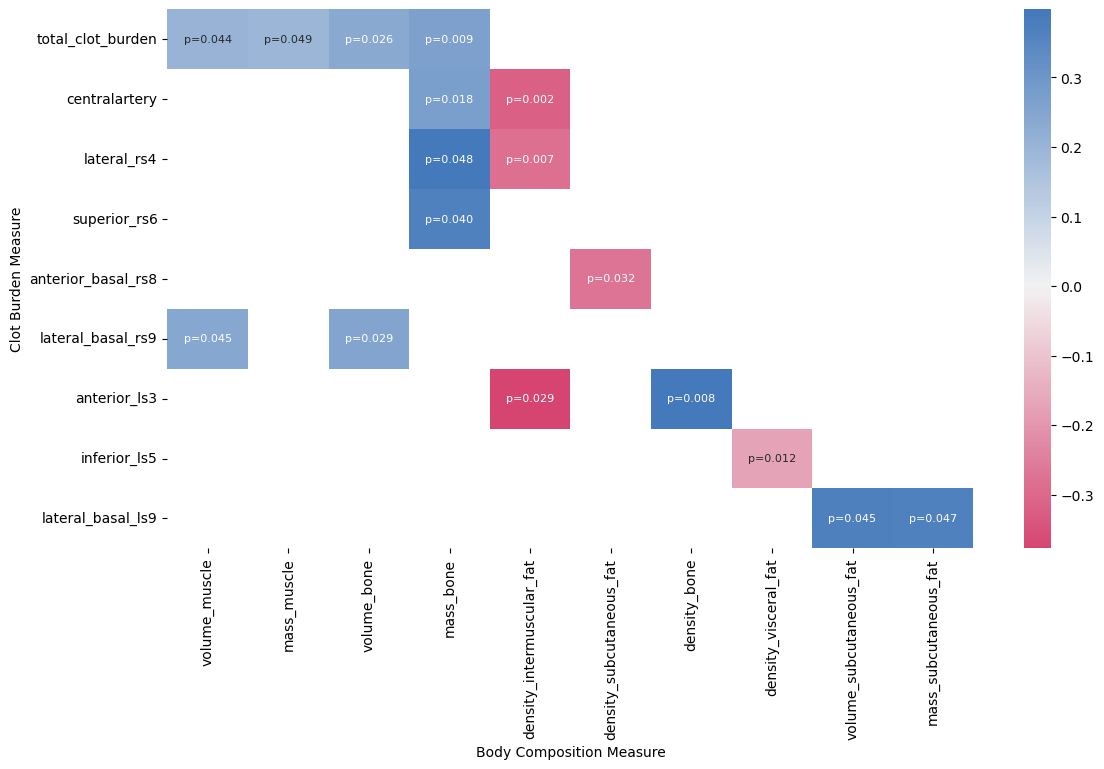

,,const_coef,const_pvalue,const_nobs,variable_coef,variable_pvalue,variable_nobs
y_var,x_var,,,,,,
centralartery,density_intermuscular_fat,-0.000,1.000,47.000,-0.318,0.002,47.000
lateral_rs4,density_intermuscular_fat,0.000,1.000,47.000,-0.282,0.007,47.000
anterior_ls3,density_bone,0.000,1.000,47.000,0.392,0.008,47.000
total_clot_burden,mass_bone,0.000,1.000,47.000,0.266,0.009,47.000
inferior_ls5,density_visceral_fat,-0.000,1.000,47.000,-0.174,0.012,47.000
centralartery,mass_bone,-0.000,1.000,47.000,0.271,0.018,47.000
total_clot_burden,volume_bone,0.000,1.000,47.000,0.237,0.026,47.000
anterior_ls3,density_intermuscular_fat,0.000,1.000,47.000,-0.377,0.029,47.000
lateral_basal_rs9,volume_bone,-0.000,1.000,47.000,0.251,0.029,47.000


In [645]:
ols = ols_regression(
	Xdata=X_scale_first,
	Ydata=Y_first, 
	targets=NUM_TARGETS,
	features=BODY_FEAT,
	controls=None
)

ols_heatmap(ols, '../figures/first_ols_cb_heatmap.png')

ols_identify_significant(ols, 0.05, '../output/regressions/first_ols_cb_sig.csv')

OLS output shape: (315, 9)


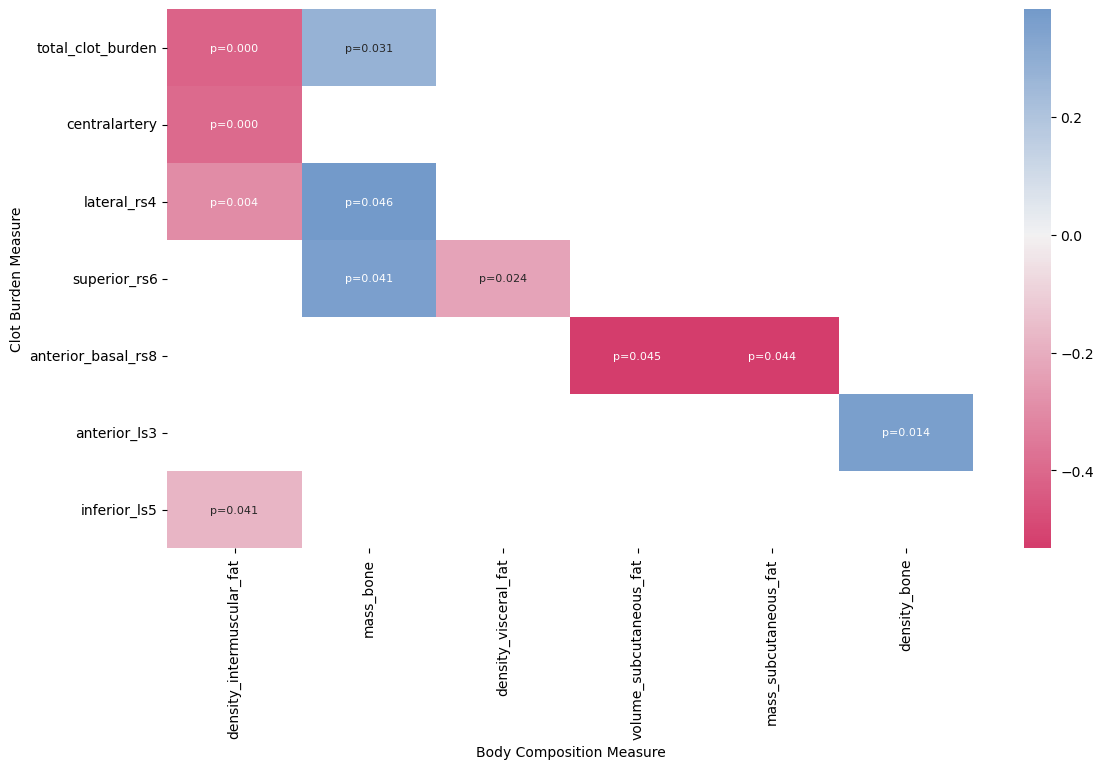

,,const_coef,const_pvalue,const_nobs,variable_coef,variable_pvalue,variable_nobs,bmi_coef,bmi_pvalue,bmi_nobs
y_var,x_var,,,,,,,,,
centralartery,density_intermuscular_fat,0.023,0.873,42.000,-0.395,0.000,42.000,0.201,0.183,42.000
total_clot_burden,density_intermuscular_fat,0.025,0.864,42.000,-0.417,0.000,42.000,0.206,0.163,42.000
lateral_rs4,density_intermuscular_fat,0.017,0.913,42.000,-0.293,0.004,42.000,0.176,0.362,42.000
anterior_ls3,density_bone,-0.020,0.894,42.000,0.364,0.014,42.000,0.060,0.727,42.000
superior_rs6,density_visceral_fat,0.014,0.931,42.000,-0.231,0.024,42.000,-0.042,0.721,42.000
total_clot_burden,mass_bone,-0.024,0.877,42.000,0.274,0.031,42.000,0.227,0.172,42.000
inferior_ls5,density_intermuscular_fat,0.010,0.949,42.000,-0.177,0.041,42.000,0.235,0.350,42.000
superior_rs6,mass_bone,-0.031,0.831,42.000,0.358,0.041,42.000,-0.018,0.867,42.000
anterior_basal_rs8,mass_subcutaneous_fat,-0.072,0.585,42.000,-0.532,0.044,42.000,0.567,0.054,42.000


In [646]:
ols = ols_regression(
	Xdata=X_scale_first,
	Ydata=Y_first, 
	targets=NUM_TARGETS,
	features=BODY_FEAT,
	controls=['bmi']
)

ols_heatmap(ols, '../figures/first_ols_cb_bmi_heatmap.png')

ols_identify_significant(ols, 0.05, '../output/regressions/first_ols_cb_sig_bmi.csv')

OLS output shape: (315, 12)


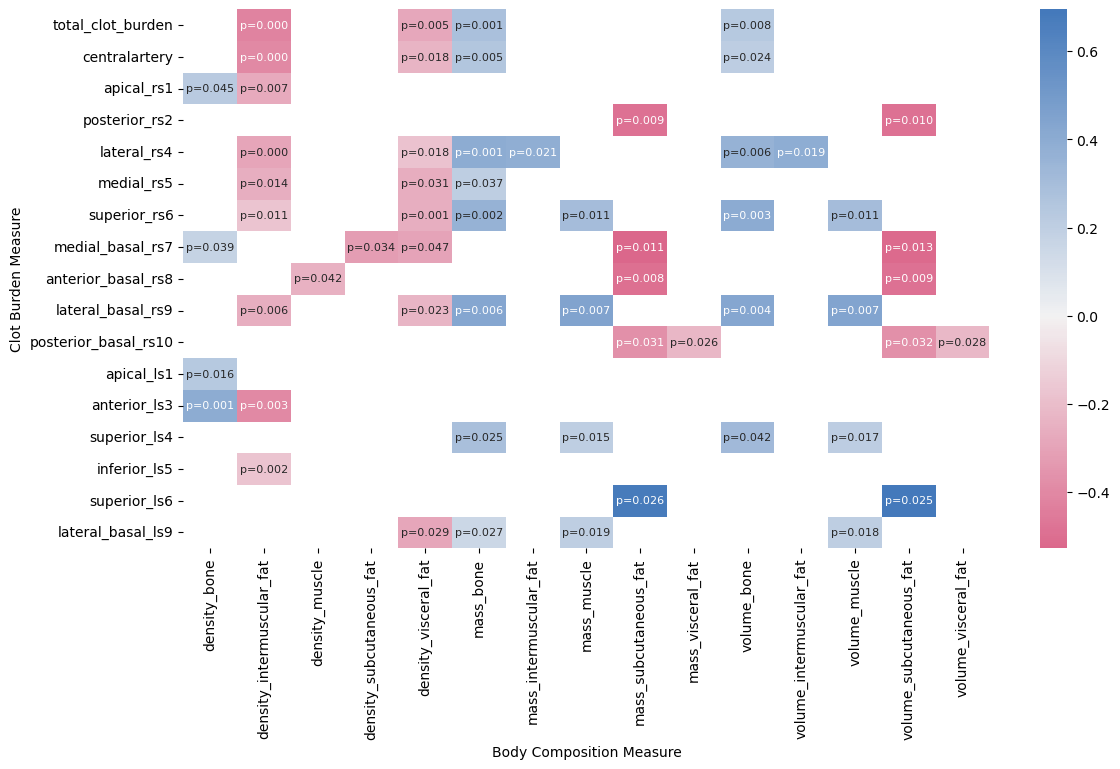

,,const_coef,const_pvalue,const_nobs,variable_coef,variable_pvalue,variable_nobs,bmi_coef,bmi_pvalue,bmi_nobs,age_coef,age_pvalue,age_nobs
y_var,x_var,,,,,,,,,,,,
total_clot_burden,density_intermuscular_fat,0.025,0.802,84.000,-0.418,0.000,84.000,0.195,0.055,84.000,-0.138,0.095,84.000
centralartery,density_intermuscular_fat,0.023,0.816,84.000,-0.396,0.000,84.000,0.192,0.067,84.000,-0.112,0.200,84.000
lateral_rs4,density_intermuscular_fat,0.017,0.870,84.000,-0.294,0.000,84.000,0.161,0.221,84.000,-0.201,0.002,84.000
superior_rs6,density_visceral_fat,0.015,0.890,84.000,-0.257,0.001,84.000,-0.057,0.496,84.000,-0.092,0.159,84.000
total_clot_burden,mass_bone,-0.024,0.815,84.000,0.282,0.001,84.000,0.215,0.065,84.000,-0.152,0.100,84.000
lateral_rs4,mass_bone,-0.034,0.722,84.000,0.394,0.001,84.000,0.146,0.251,84.000,-0.221,0.002,84.000
anterior_ls3,density_bone,-0.021,0.831,84.000,0.394,0.001,84.000,0.063,0.582,84.000,0.077,0.453,84.000
superior_rs6,mass_bone,-0.031,0.754,84.000,0.360,0.002,84.000,-0.022,0.770,84.000,-0.044,0.505,84.000
inferior_ls5,density_intermuscular_fat,0.010,0.925,84.000,-0.176,0.002,84.000,0.241,0.159,84.000,0.087,0.167,84.000


In [647]:
ols = ols_regression(
	Xdata=X_scale_first,
	Ydata=Y_first, 
	targets=NUM_TARGETS,
	features=BODY_FEAT,
	controls=['bmi', 'age']
)

ols_heatmap(ols, '../figures/first_ols_cb_bmi_age_heatmap.png')

ols_identify_significant(ols, 0.05, '../output/regressions/first_ols_cb_sig_bmi_age.csv')

### All Observations

OLS output shape: (315, 6)


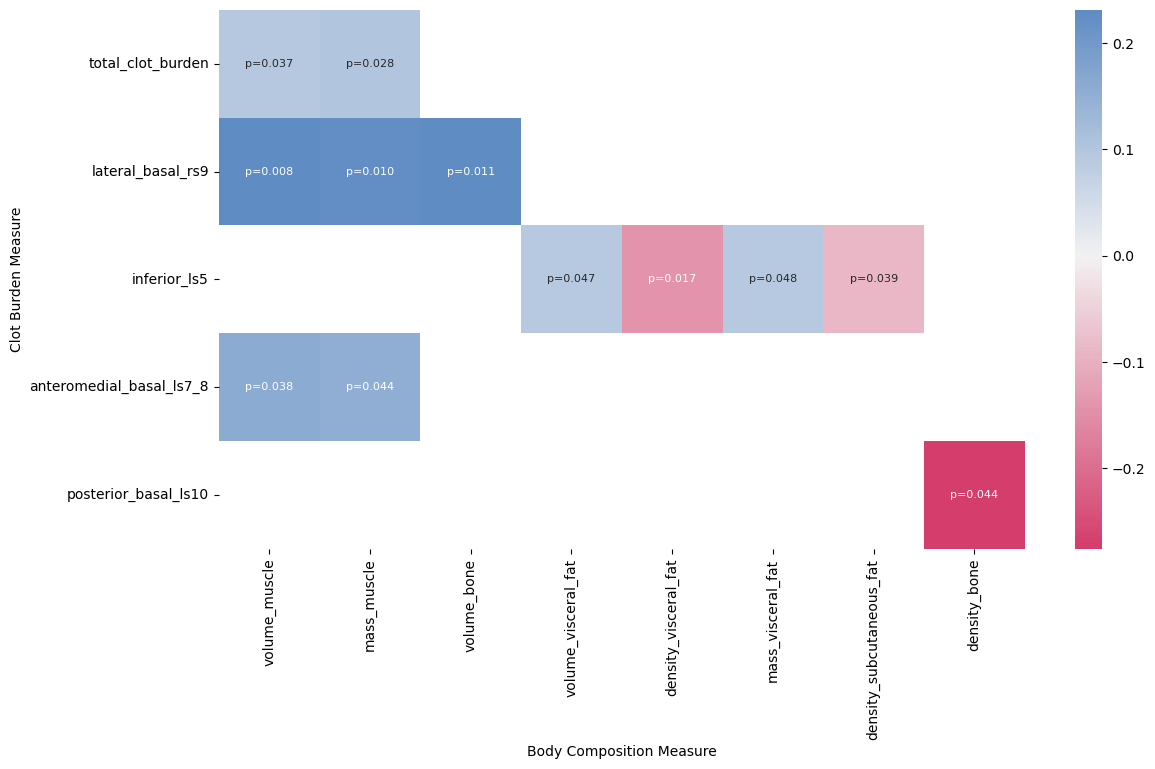

In [648]:
ols = ols_regression(
	Xdata=X_scale_all,
	Ydata=Y_all, 
	targets=NUM_TARGETS,
	features=BODY_FEAT
)

ols_heatmap(ols, '../figures/all_ols_cb_heatmap.png')

ols_identify_significant(ols, 0.05, '../output/regressions/all_ols_cb_sig.csv')

OLS output shape: (315, 9)


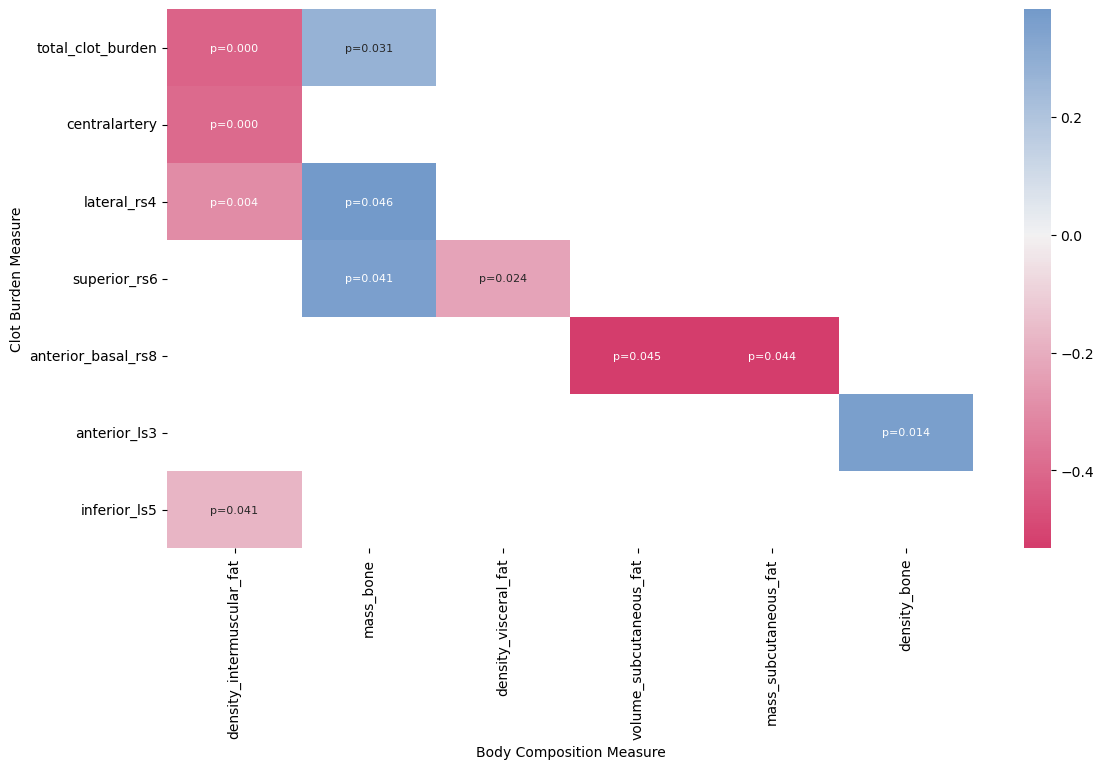

,,const_coef,const_pvalue,const_nobs,variable_coef,variable_pvalue,variable_nobs,bmi_coef,bmi_pvalue,bmi_nobs
y_var,x_var,,,,,,,,,
centralartery,density_intermuscular_fat,0.023,0.873,42.000,-0.395,0.000,42.000,0.201,0.183,42.000
total_clot_burden,density_intermuscular_fat,0.025,0.864,42.000,-0.417,0.000,42.000,0.206,0.163,42.000
lateral_rs4,density_intermuscular_fat,0.017,0.913,42.000,-0.293,0.004,42.000,0.176,0.362,42.000
anterior_ls3,density_bone,-0.020,0.894,42.000,0.364,0.014,42.000,0.060,0.727,42.000
superior_rs6,density_visceral_fat,0.014,0.931,42.000,-0.231,0.024,42.000,-0.042,0.721,42.000
total_clot_burden,mass_bone,-0.024,0.877,42.000,0.274,0.031,42.000,0.227,0.172,42.000
inferior_ls5,density_intermuscular_fat,0.010,0.949,42.000,-0.177,0.041,42.000,0.235,0.350,42.000
superior_rs6,mass_bone,-0.031,0.831,42.000,0.358,0.041,42.000,-0.018,0.867,42.000
anterior_basal_rs8,mass_subcutaneous_fat,-0.072,0.585,42.000,-0.532,0.044,42.000,0.567,0.054,42.000


In [649]:
ols = ols_regression(
	Xdata=X_scale_first,
	Ydata=Y_first, 
	targets=NUM_TARGETS,
	features=BODY_FEAT,
	controls=['bmi']
)

ols_heatmap(ols, '../figures/all_ols_cb_bmi_heatmap.png')

ols_identify_significant(ols, 0.05, '../output/regressions/all_ols_cb_sig_bmi.csv')

OLS output shape: (315, 12)


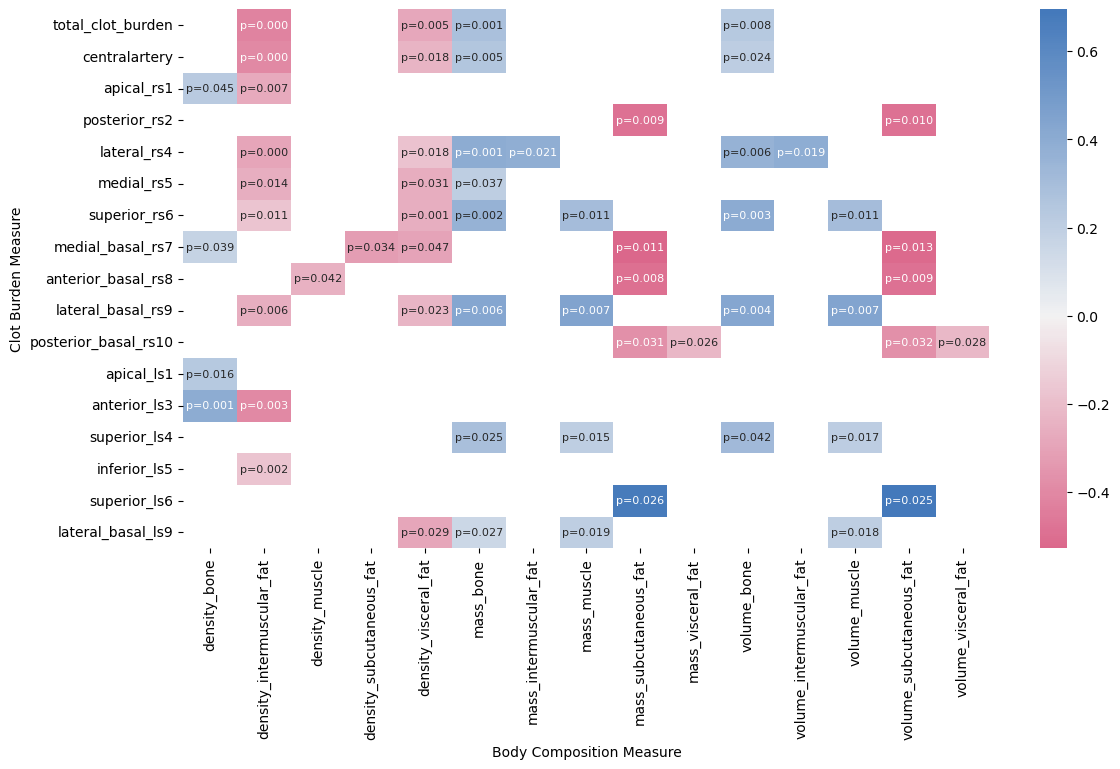

,,const_coef,const_pvalue,const_nobs,variable_coef,variable_pvalue,variable_nobs,bmi_coef,bmi_pvalue,bmi_nobs,age_coef,age_pvalue,age_nobs
y_var,x_var,,,,,,,,,,,,
total_clot_burden,density_intermuscular_fat,0.025,0.802,84.000,-0.418,0.000,84.000,0.195,0.055,84.000,-0.138,0.095,84.000
centralartery,density_intermuscular_fat,0.023,0.816,84.000,-0.396,0.000,84.000,0.192,0.067,84.000,-0.112,0.200,84.000
lateral_rs4,density_intermuscular_fat,0.017,0.870,84.000,-0.294,0.000,84.000,0.161,0.221,84.000,-0.201,0.002,84.000
superior_rs6,density_visceral_fat,0.015,0.890,84.000,-0.257,0.001,84.000,-0.057,0.496,84.000,-0.092,0.159,84.000
total_clot_burden,mass_bone,-0.024,0.815,84.000,0.282,0.001,84.000,0.215,0.065,84.000,-0.152,0.100,84.000
lateral_rs4,mass_bone,-0.034,0.722,84.000,0.394,0.001,84.000,0.146,0.251,84.000,-0.221,0.002,84.000
anterior_ls3,density_bone,-0.021,0.831,84.000,0.394,0.001,84.000,0.063,0.582,84.000,0.077,0.453,84.000
superior_rs6,mass_bone,-0.031,0.754,84.000,0.360,0.002,84.000,-0.022,0.770,84.000,-0.044,0.505,84.000
inferior_ls5,density_intermuscular_fat,0.010,0.925,84.000,-0.176,0.002,84.000,0.241,0.159,84.000,0.087,0.167,84.000


In [650]:
ols = ols_regression(
	Xdata=X_scale_first,
	Ydata=Y_first, 
	targets=NUM_TARGETS,
	features=BODY_FEAT,
	controls=['bmi', 'age']
)

ols_heatmap(ols, '../figures/first_ols_cb_bmi_age_heatmap.png')

ols_identify_significant(ols, 0.05, '../output/regressions/all_ols_cb_sig_bmi_age.csv')

# Logit Regression

## Standardize Data

In [729]:
# Standardize data
scaler = StandardScaler()
X_scale_first = pd.DataFrame(
	scaler.fit_transform(X_first),
	columns=X_first.columns,
	index=X_first.index
)
X_scale_all = pd.DataFrame(
	scaler.fit_transform(X_all),
	columns=X_all.columns,
	index=X_all.index
)

print(f"X_body_first.shape: {X_scale_first.shape}")
print(f"X_body_all.shape: {X_scale_all.shape}")

X_body_first.shape: (47, 65)
X_body_all.shape: (99, 65)


## Dependent Variable: PE Resolution

### All observations

In [728]:
Y = Y_first.copy()
Y['resolved_pe'].value_counts(dropna=False)


Unresolved    27
Resolved      15
NaN            5
Name: resolved_pe, dtype: int64

In [733]:
# # Non-null indices
non_null_resolved = set(Y.loc[pd.notnull(Y['resolved_pe']), :].index)
non_null_exog = set(X_scale_first.loc[pd.notnull(X_scale_first['volume_subcutaneous_fat']), :].index)
non_null_all = list(non_null_resolved.intersection(non_null_exog))
print(len(non_null_all))

Y = pd.DataFrame(
	Y.loc[non_null_all, :],
	columns=['resolved_pe'],
	index=non_null_all
).sort_index()
X_scale_first = pd.DataFrame(
	X_scale_first.loc[non_null_all, :],
	columns=X_scale_first.columns,
	index=non_null_all
).sort_index()
print(Y.shape)
print(X_scale_first.shape)

42
(42, 1)
(42, 65)


In [734]:
y = pd.DataFrame(
	LabelEncoder().fit_transform(Y['resolved_pe']),
	columns=['resolved_pe'],
	index=Y.index
).astype(np.int64)
y.head()

,resolved_pe
PE12_0,1
PE14_0,1
PE15_0,1
PE16_0,1
PE17_0,1


In [735]:
y.value_counts(dropna=False)

resolved_pe
1              27
0              15
dtype: int64

In [736]:
X_scale_first.loc[:, 'volume_subcutaneous_fat'].info()

<class 'pandas.core.series.Series'>
Index: 42 entries, PE12_0 to PE9_0
Series name: volume_subcutaneous_fat
Non-Null Count  Dtype  
--------------  -----  
42 non-null     float64
dtypes: float64(1)
memory usage: 672.0+ bytes


In [737]:
X_temp = X_scale_first.loc[:, ['volume_subcutaneous_fat']]
logit_temp = sm.Logit(y, X_temp).fit()
logit_temp.params

Optimization terminated successfully.
         Current function value: 0.682888
         Iterations 4


volume_subcutaneous_fat    0.318115
dtype: float64

In [720]:
X_temp.shape

(42, 1)

In [721]:
y.shape

(47, 1)